## Transaction Log Usage with Prediction of Databases
As a DBA, I need information about the transaction logging subsystem for the currently connected databases to determine whether I need to adjust corresponding configuration parameters, in order to to avoid that the  log space might be running out.

* Transaction Log Usage of Databases by Hour

### Step 1. Load Db2 Extension
Before running all the following examples, you need to load the Db2 extention so that you can use the magic command `%sql`.

The cell below will load the Db2 extension. Note that it will take a few seconds for the extension to load, so you need to wait till the message "Db2 Extensions Loaded" is displayed. You can find more information about the Db2 extension at https://github.com/DB2-Samples/db2jupyter.

In [2]:
%run db2.jupyter.ipynb

Pixiedust database opened successfully


DB2 Extensions Loaded.


### Step 2. Connect to Db2
Before you run any SQL commands, you must create a connection to your target database by using the following command syntax:

     %sql CONNECT TO [db_name] USER [user_name] USING [password]|[?] HOST [IP_address] PORT [port]

   * db_name - Database name to be connected. Use your DSM repository database name as the input.
   * user_name - User ID to connect to the database.
   * password - If `?` is used for the password, you must manully input the password when prompted.
   * IP_address - Use `localhost` or IP address if you are connecting to a remote server.
   * port - Port number to connect your database
    
The message "Connection successful" will be displayed when the connection is created successfully. 

You can update the connection parameters and credential to another database if necessary.

In [3]:
%sql CONNECT TO test213 USER db2inst1 USING ? HOST 9.30.253.63 PORT 50002

Password [password]: ········
Connection successful.


### Parameter Description 
In each of the following examples, we use the `queryCondition` keyword to pass the values of the following parameters in order to pull history data through the repository view: 
* DB_CONN_ID: Connection name of the monitored database that you add to the DSM.
* END_TIME: Target end time that you want to query.
* INTERVAL: int(1~100), which stands for time period(hours) before the END_TIME.
* REPORT_TYPE: Log (this is the only value)
   
Format of input: 
* queryCondition = "DB_CONN_ID='irww' END_TIME='2018-01-05-00:00:00' INTERVAL=18 REPORT_TYPE='log'"

Note: 
1. All parameters must be separated by a whitespace.
2. If the value of any parameter is changed, you must click [Save and Checkpoint] to save the changes before running the `%run` command.

You can find the details of the implementation in the notebook `transaction-log-usage-with-prediction-scripts.jupyter.ipynb`.


### Example 1: 
This example shows how to use SQL statements to get the log usage from the repository view `MON_GET_TRANSACTION_LOG`. From the report, you can find the information of the transaction logging subsystem on the currently connected database.
* TOTAL_LOG_USED_KB: The total amount of active log space currently that is used (in KB) in the database.
* TOTAL_LOG_AVAILABLE_KB: The amount of active log space in the database that is not being used by uncommitted transactions (in KB).
* ACTIVE_LOG_USED_PERCENT: Percentage of active log space that is used.
* TOT_LOG_USED_TOP_KB: The maximum amount of total log space that is used (in KB), which includes space used in both primary and secondary log files.
* SEC_LOG_USED_TOP_KB: The maximum amount of secondary log space that is used (in KB).
* SEC_LOGS_ALLOCATED: The total number of secondary log files that are currently being used for the database.


With the conjunction of `TOTAL_LOG_USED` and `TOTAL_LOG_AVAILABLE`, you can determine whether you might need to adjust configuration parameters `LOGFILSIZ`, `LOGPRIMARY` and `LOGSECOND` to avoid that log space might be running out.

With the conjunction of `TOT_LOG_USED_TOP`, `SEC_LOG_USED_TOP` and `SEC_LOGS_ALLOCATED`, you can find the current dependency on
secondary logs. Also, you might need to adjust configuration parameters `LOGFILSIZ`, `LOGPRIMARY`, `LOGSECOND` and `LOGARCHMETH1` if necessary.


Besides showing the data of transcation logging in the past, we also forcast the Maximum and Avgerage log usage for next a few hours.
In this example, ARIMA time series algorithm is used to build predictive model.
Forcast data are showing together with history data in same graph with RED dot and darker background color.  

How well the model is, pls refer to notebook ARIMA-Analysis.jupyter.ipynb.

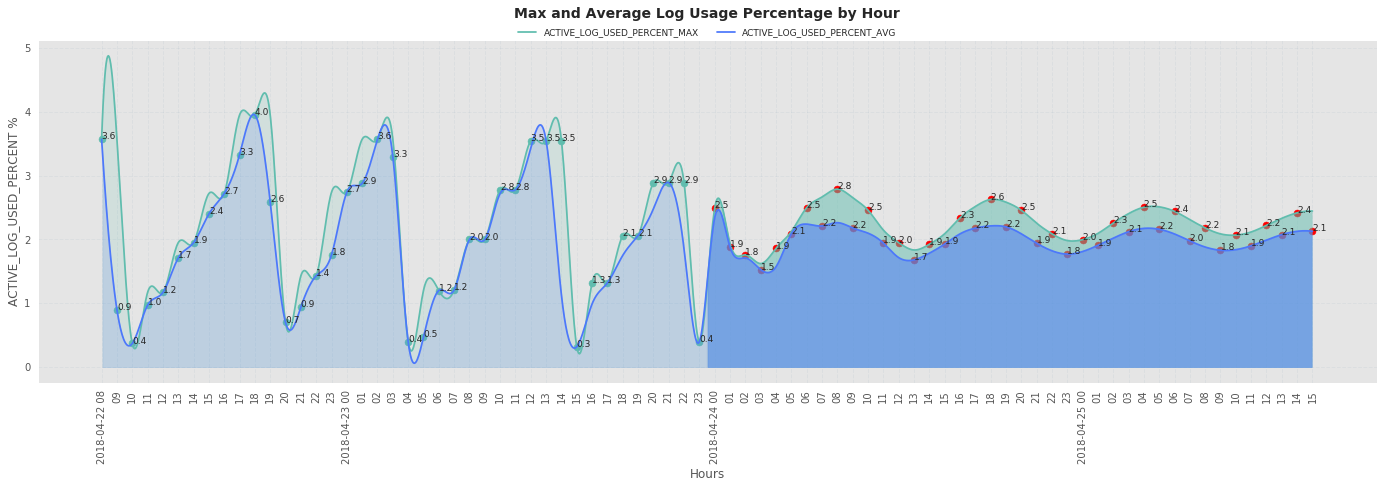

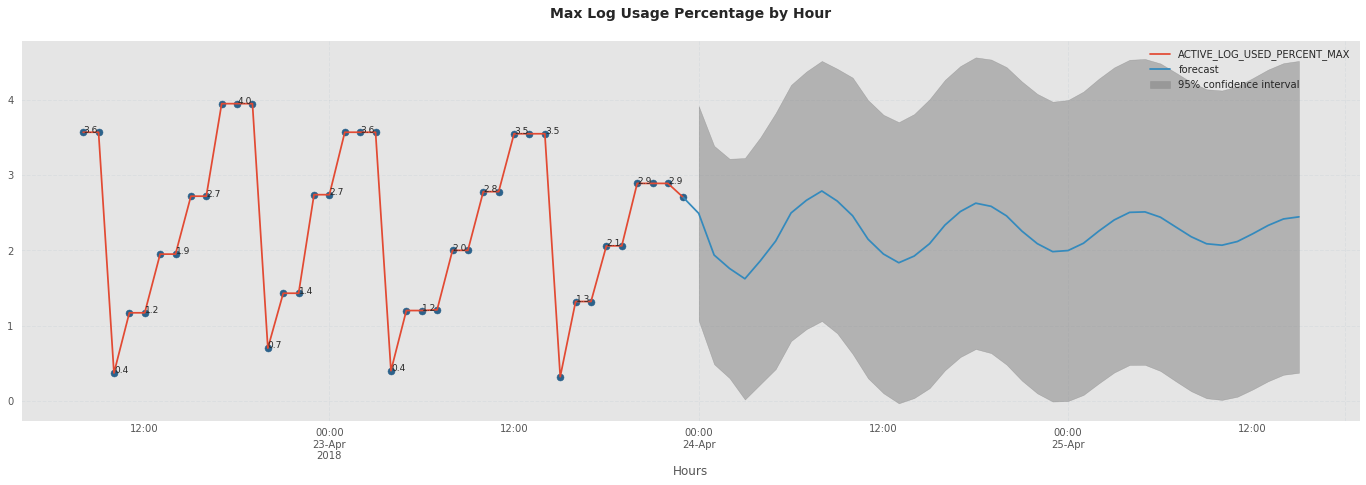

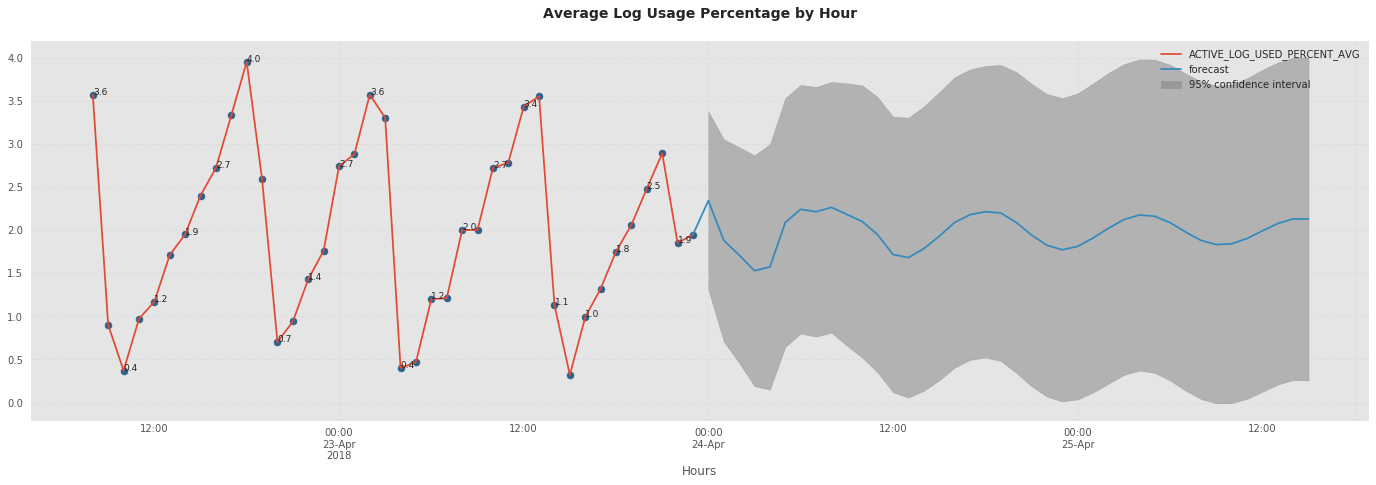

ACTIVE_LOG_USED_PERCENT_AVG  ACTIVE_LOG_USED_PERCENT_MAX  \
DATE       HOURS                                                             
2018-04-22 8                             3.57                         3.57   
           9                             0.90                         3.57   
           10                            0.37                         0.37   
           11                            0.97                         1.17   
           12                            1.17                         1.17   
           13                            1.71                         1.95   
           14                            1.95                         1.95   
           15                            2.40                         2.72   
           16                            2.72                         2.72   
           17                            3.33                         3.95   
           18                            3.95                         3.95   
           19                            2.59                         3.95   
           20                            0.70                         0.70   
           21                            0.94                         1.43   
           22                            1.43                         1.43   
           23                            1.76                         2.74   
2018-04-23 0                             2.74                         2.74   
           1                             2.88                         3.57   
           2                             3.57                         3.57   
           3                             3.30                         3.57   
           4                             0.40                         0.40   
           5                             0.47                         1.20   
           6                             1.20                         1.20   
           7                             1.21                         1.21   
           8                             2.00                         2.00   
           9                             2.00                         2.00   
           10                            2.72                         2.78   
           11                            2.78                         2.78   
           12                            3.43                         3.55   
           13                            3.55                         3.55   
           14                            1.13                         3.55   
           15                            0.32                         0.32   
           16                            0.99                         1.32   
           17                            1.32                         1.32   
           18                            1.75                         2.06   
           19                            2.06                         2.06   
           20                            2.48                         2.89   
           21                            2.89                         2.89   
           22                            1.85                         2.89   
           23                            0.40                         0.40   

                  SEC_LOGS_ALLOCATED_AVG  SEC_LOGS_ALLOCATED_MAX  \
DATE       HOURS                                                   
2018-04-22 8                           0                       0   
           9                           0                       0   
           10                          0                       0   
           11                          0                       0   
           12                          0                       0   
           13                          0                       0   
           14                          0                       0   
           15                          0                       0   
           16                          0                     

In [52]:
# load pandas for dataframe support
import pandas as pd

# input value of parameters to pull history data through repository view
queryCondition = "DB_CONN_ID='repo215' END_TIME='2018-04-24-00:00:00' INTERVAL=40 REPORT_TYPE='log'"

# pass the values to a variable
!echo $queryCondition > logCondition

# get content from the variable and pass values to select statement 
# run select statment to get log usage data for specified connection and save as a CSV file
# predict log usage in the near future
# display log usage together with preditive data in graph
%run transaction-log-usage-with-prediction-scripts.jupyter.ipynb

# set maximum rows of a table as general
pd.options.display.max_rows = 999

# define object for dataframe and pivot table
log_df = None
log_table = None

# check whether CSV file has been created which means select statement run successfully
# pass content of CSV to dataframe object
# draw pivot table according to dataframe
if os.path.exists("log.csv") and (len(GENERAL_ERROR) == 0):
    log_df = pd.read_csv("log.csv", index_col=0)
    log_table = pd.pivot_table(log_df,index=['DATE','HOURS'], fill_value=0)
    
# display pivot table  
log_table